In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
networkLoss = []
iterations = []

# define a neural network to train

pinn = FCN(1,1,50,1) # for psi p
t_boundary0 = torch.tensor(0.5).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


pinn2 = FCN(1,1,50,1) # for psi c
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)
t2_boundary2 = torch.tensor(1.5).view(-1,1).requires_grad_(True)


In [ ]:
# define training points over the entire domain, for the physics loss
t_physics3 = torch.linspace(0.5,0.8,30).view(-1,1).requires_grad_(True)
t_physics4 = torch.linspace(0.8,1.0, 50).view(-1,1).requires_grad_(True)
t_physics = torch.cat((t_physics3,t_physics4))
t_test = torch.linspace(0.5,1,300).view(-1,1)

t2_physics1 = torch.linspace(1.,1.25,25).view(-1,1).requires_grad_(True)
t2_physics2 = torch.linspace(1.25,1.5,50).view(-1,1).requires_grad_(True)
t2_physics = torch.cat((t2_physics1,t2_physics2))
#t2_physics = torch.linspace(1.,1.5,50).view(-1,1).requires_grad_(True)
t2_test = torch.linspace(1.,1.5,300).view(-1,1)

# train the PINN
psi_s = 1
lambd = 0.1
lambd_f = 0.3

In [ ]:
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-2)
optimiser2 = torch.optim.Adam(pinn2.parameters(),lr=1e-2)

Cumulative Losses: 
tensor(6.0796, grad_fn=<AddBackward0>)


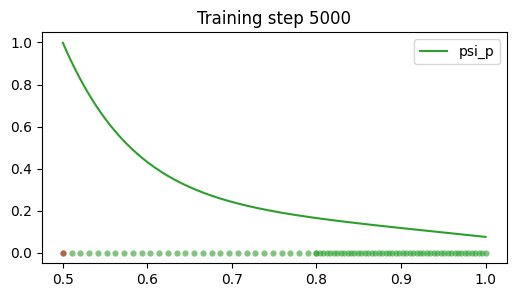

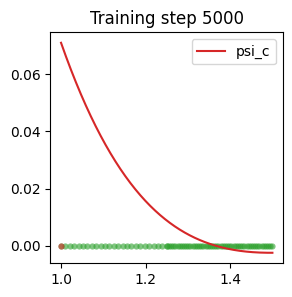

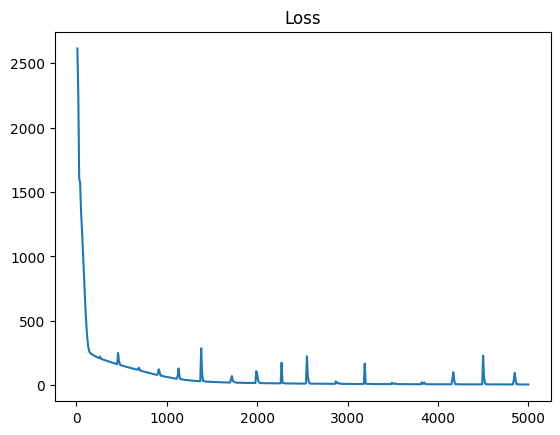

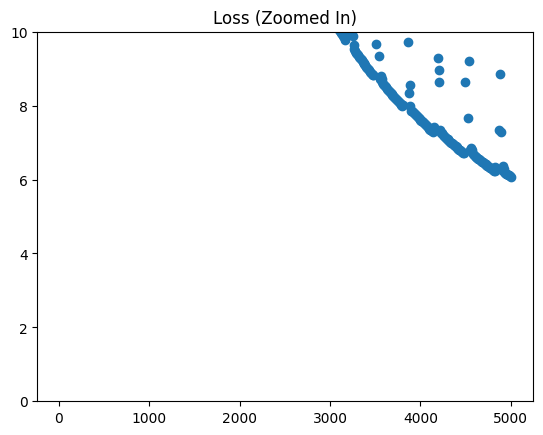

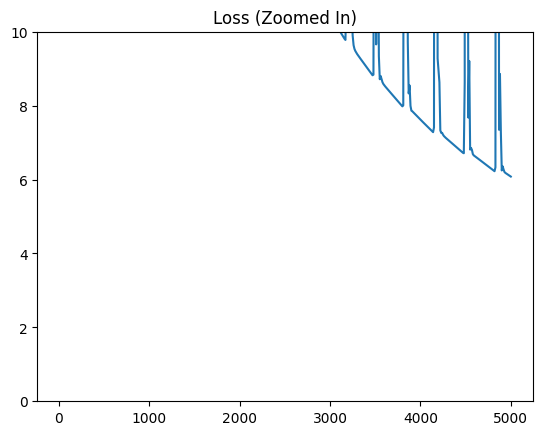

Cumulative Losses: 
tensor(2.9656, grad_fn=<AddBackward0>)


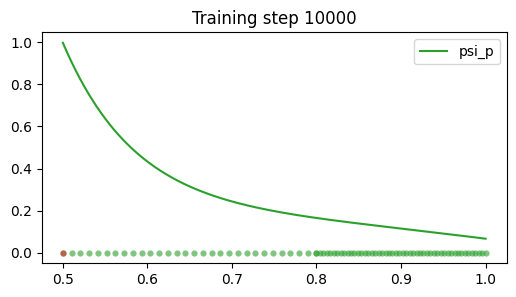

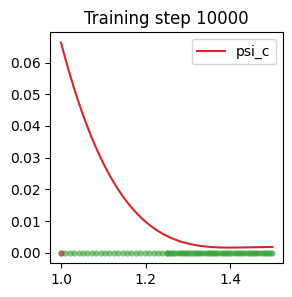

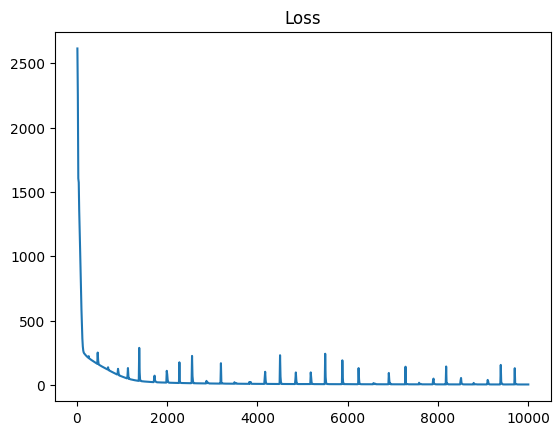

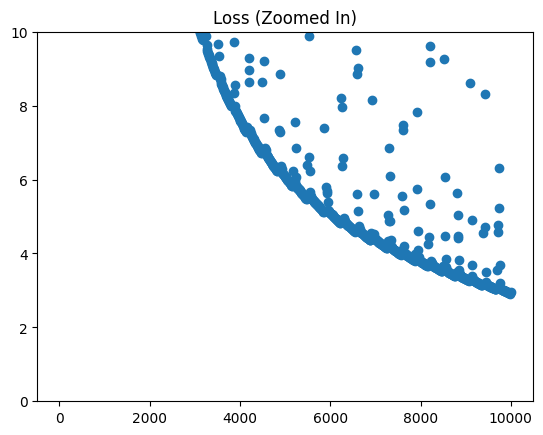

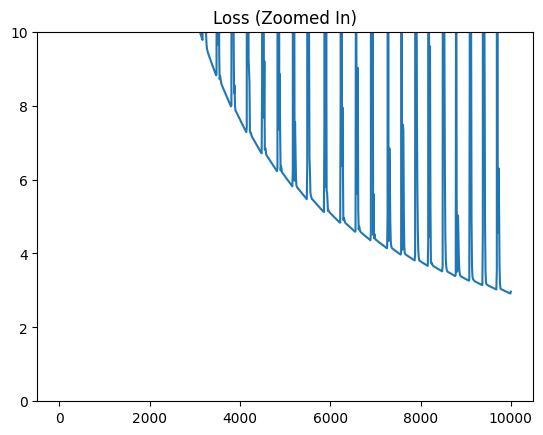

Cumulative Losses: 
tensor(1.6965, grad_fn=<AddBackward0>)


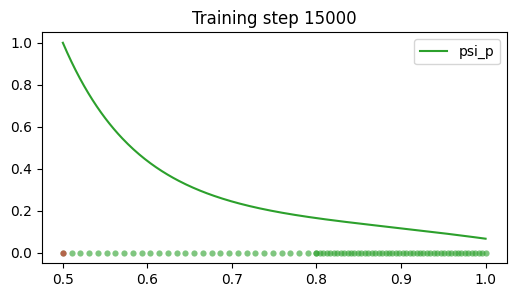

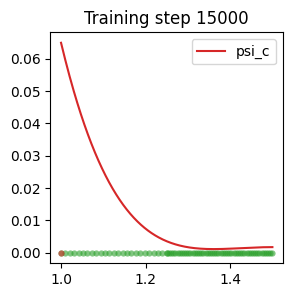

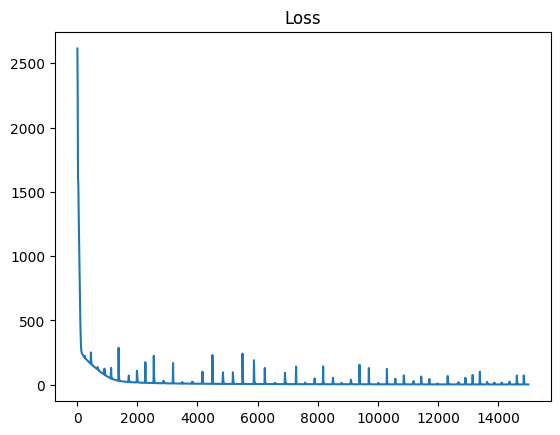

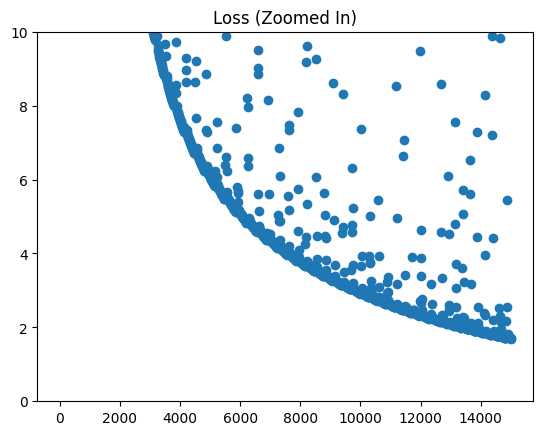

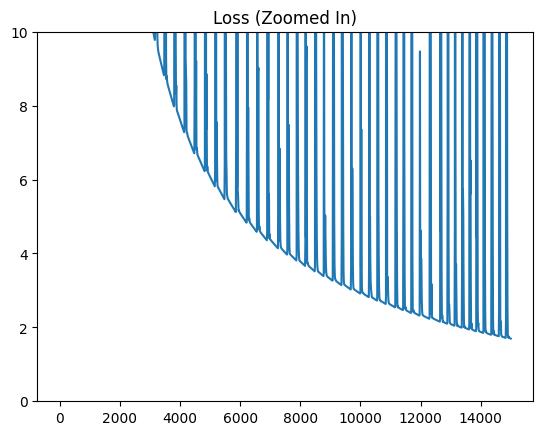

Cumulative Losses: 
tensor(1.1507, grad_fn=<AddBackward0>)


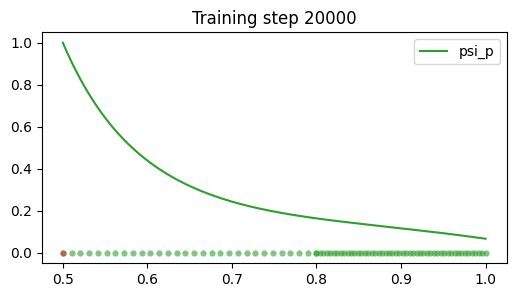

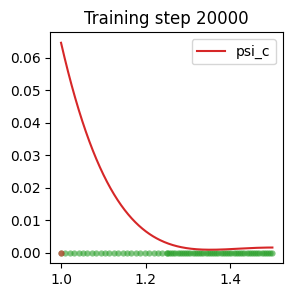

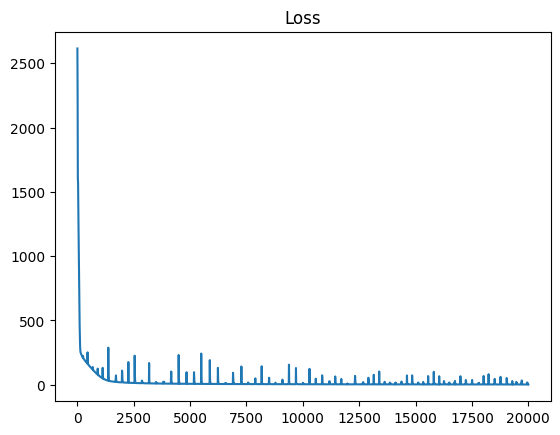

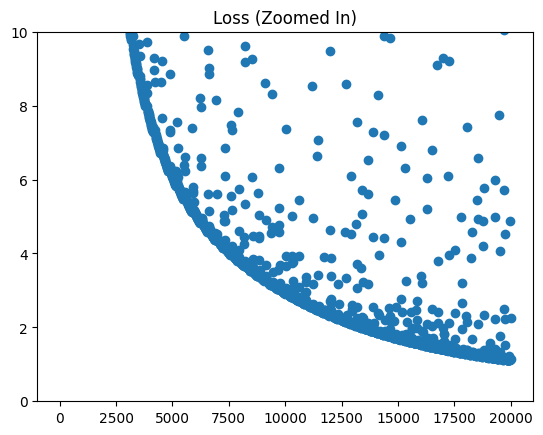

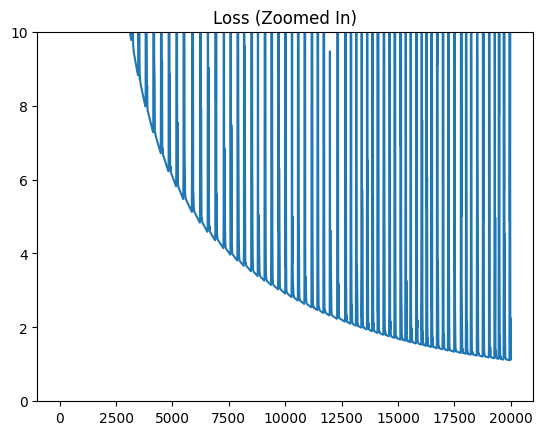

Cumulative Losses: 
tensor(1.6340, grad_fn=<AddBackward0>)


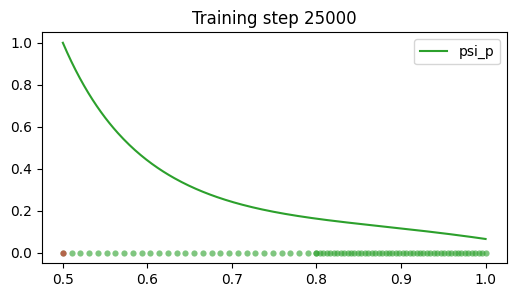

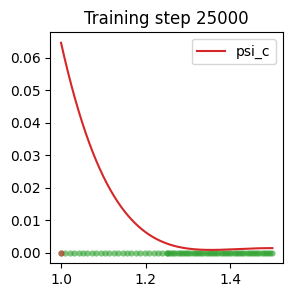

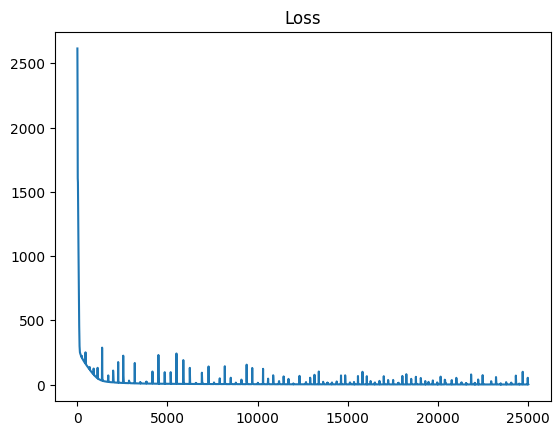

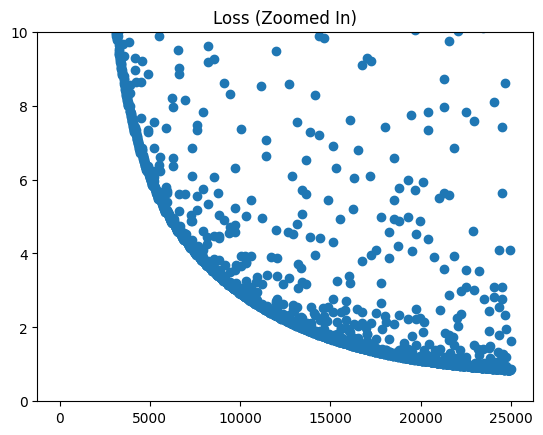

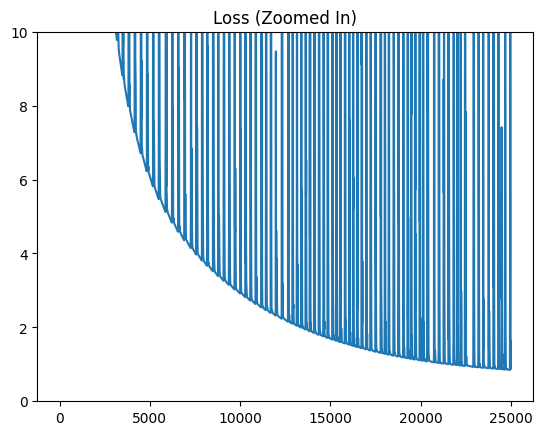

Cumulative Losses: 
tensor(0.7122, grad_fn=<AddBackward0>)


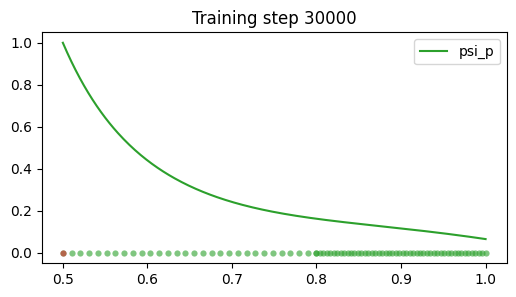

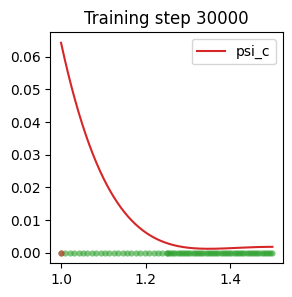

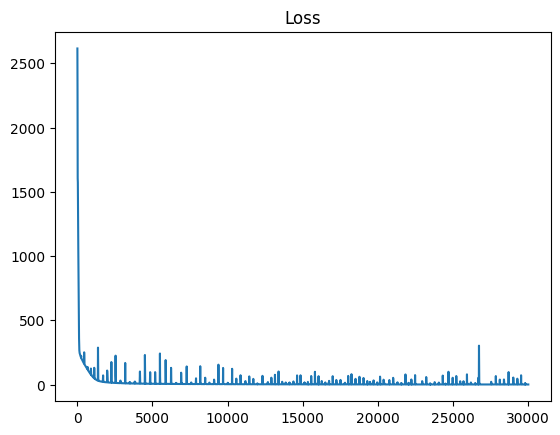

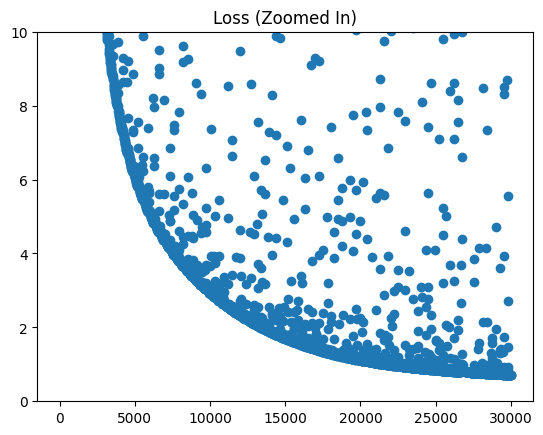

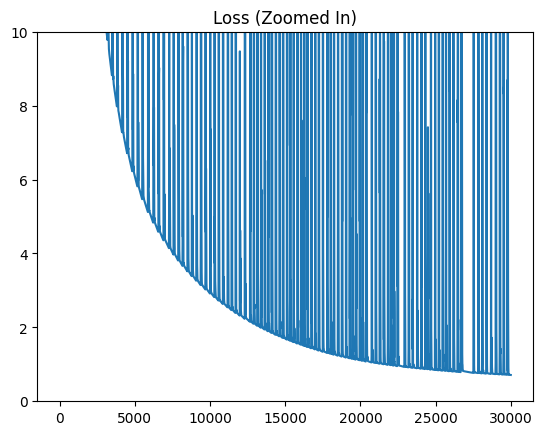

Cumulative Losses: 
tensor(0.6280, grad_fn=<AddBackward0>)


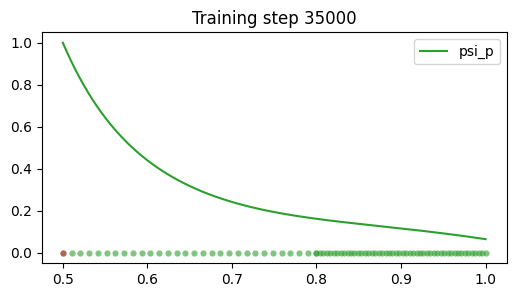

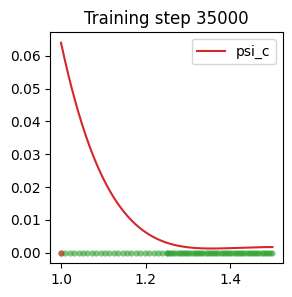

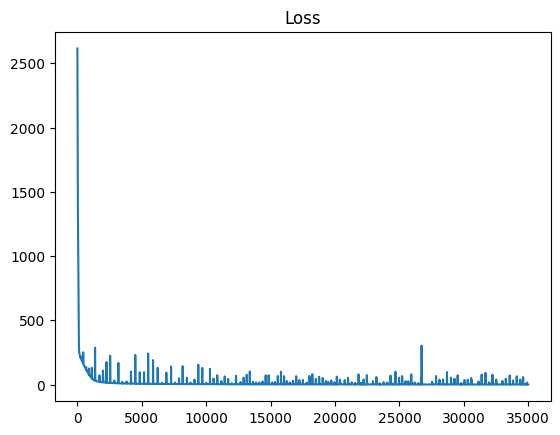

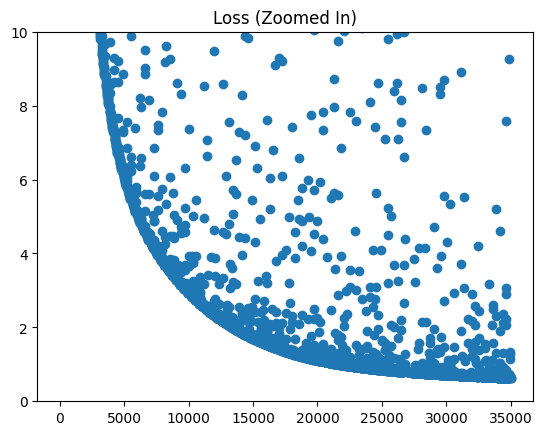

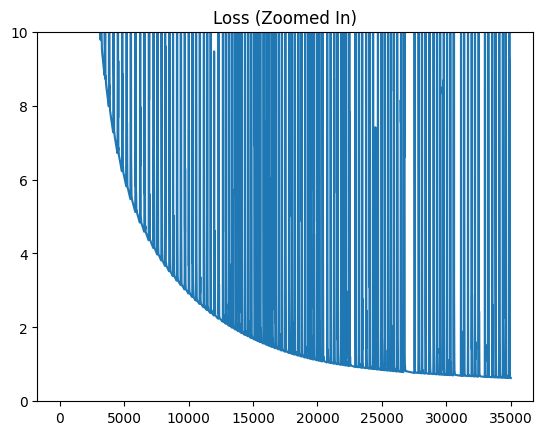

Cumulative Losses: 
tensor(0.5602, grad_fn=<AddBackward0>)


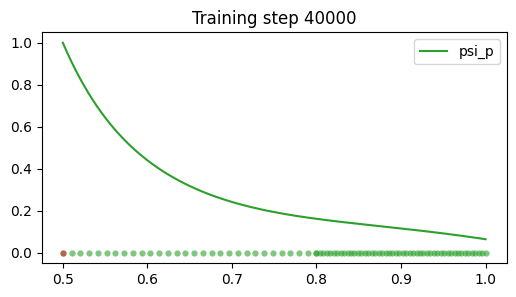

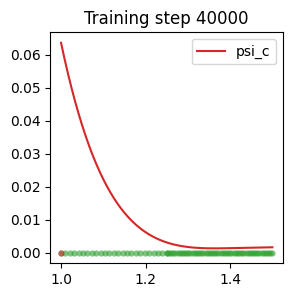

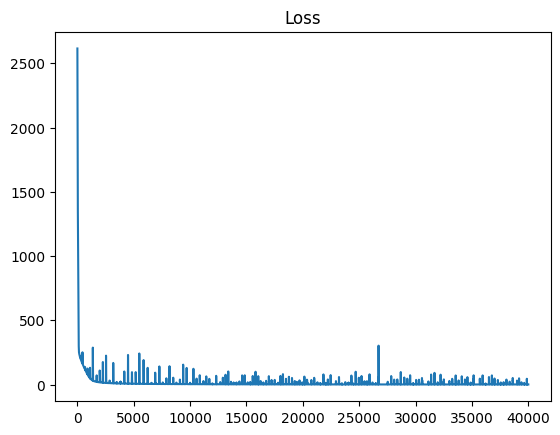

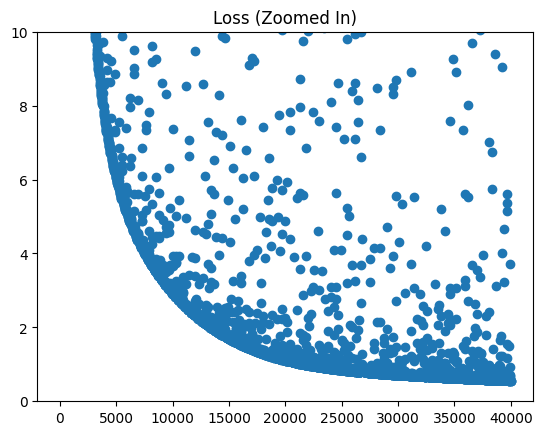

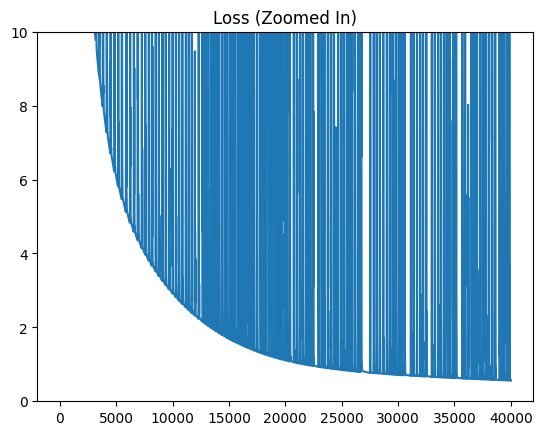

In [ ]:
loss2, loss_psi_c = 0,0
#training loop

for i in range(40001):
    optimiser.zero_grad()
    optimiser2.zero_grad()

    u1 = pinn(t_boundary0) #boundary at 0; psi p at 0
    u2 = pinn(t2_boundary1) #boundary at 1; psi p at b
    y1 = pinn2(t2_boundary1) #boundary at 1; psi c at b



    loss1 = (torch.squeeze(u1) - psi_s)**2 #psi_p loss 1
    loss1 = loss1*5000
    u = pinn(t_physics)#psi p from 0.5 to 1.0

    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss2 = torch.mean(((d2udt2 * t_physics) + (dudt) - (torch.sinh(u) * t_physics/(lambd*lambd)) + (1/(lambd_f * lambd_f)))**2) #psi_p eqn loss 2

    if i > 0:
      dy1dt = torch.autograd.grad(y1, t2_boundary1, torch.ones_like(y1), create_graph=True)[0]#psi_c'(b)
      du2dt = torch.autograd.grad(u2, t2_boundary1, torch.ones_like(u2), create_graph=True)[0]#psi_p'(b)
      loss21 = (torch.squeeze(dy1dt) - torch.squeeze(du2dt))**2 #psi_c loss 1
      loss22 = (torch.squeeze(y1) - torch.squeeze(u2))**2 #psi_c loss 2

      y2 = pinn2(t2_boundary2)#psi_c(1.5)
      dy2dt = torch.autograd.grad(y2, t2_boundary2, torch.ones_like(y2), create_graph=True)[0]#psi_c'(1.5)
      loss23 = (torch.squeeze(dy2dt) - 0)**2 #psi_c loss 3

      y = pinn2(t2_physics)
      dydt = torch.autograd.grad(y, t2_physics, torch.ones_like(y), create_graph=True)[0]
      d2ydt2 = torch.autograd.grad(dydt, t2_physics, torch.ones_like(dydt), create_graph=True)[0]
      #u = pinn(t_physics).detach()
      loss24 = torch.mean(((d2ydt2 * t2_physics)+(dydt)-(torch.sinh(y) * t2_physics /(lambd * lambd)))**2)#psi_c eqn loss 4

      # backpropagate joint loss, take optimiser step
      # TODO: write code here

      loss = loss1 + loss2 + 1000*loss21 + 10000*loss22 + 10000*loss23 + loss24

      if i % 10 == 0:
        networkLoss.append(loss.item())
        iterations.append(i)

      loss.backward()
      optimiser.step()
      optimiser2.step()

      # plot the result as training progresses
      if i % 5000 == 0:
          #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
          u = pinn(t_test).detach()
          print("Cumulative Losses: ")
          print(loss)
          plt.figure(figsize=(6,3))
          plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary0.detach()[:,0],
                        torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t_test[:,0], u[:,0], label="psi_p", color="tab:green")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          y = pinn2(t2_test).detach()
          #print(loss)
          plt.figure(figsize=(3,3))
          plt.scatter(t2_physics.detach()[:,0],
                        torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary1.detach()[:,0],
                        torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t2_test[:,0], y[:,0], label="psi_c", color="tab:red")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          plt.figure()
          plt.plot(iterations, networkLoss)
          plt.title("Loss")
          plt.show()

          plt.figure()
          plt.ylim(0, 10)
          plt.scatter(iterations, networkLoss)
          plt.title("Loss (Zoomed In)")
          plt.show()

          plt.figure()
          plt.ylim(0, 10)
          plt.plot(iterations, networkLoss)
          plt.title("Loss (Zoomed In)")
          plt.show()


In [ ]:
u = pinn(t_test).detach()
y = pinn2(t2_test).detach()

plt.figure(figsize=(9,6))

plt.xlim(0.5,1.5)
plt.ylim(0,1)
plt.plot(t_test[:,0], u[:,0], label="psi_p", color="tab:green")#plots PINN solution
plt.plot(t2_test[:,0], y[:,0], label="psi_c", color="tab:red")
plt.title("PINN Solution")
plt.legend()
plt.show()

In [ ]:
torch.manual_seed(123)

networkLoss = []
iterations = []

# define a neural network to train


pinn101 = FCN(1,1,50,1) # for psi p
t_boundary0 = torch.tensor(0.5).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


pinn102 = FCN(1,1,50,1) # for psi c
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)
t2_boundary2 = torch.tensor(1.5).view(-1,1).requires_grad_(True)



# define training points over the entire domain, for the physics loss

t_physics3 = torch.linspace(0.5,0.8,30).view(-1,1).requires_grad_(True)
t_physics4 = torch.linspace(0.8,1.0, 50).view(-1,1).requires_grad_(True)
t_physics = torch.cat((t_physics3,t_physics4))
t_test = torch.linspace(0.5,1,300).view(-1,1)

t2_physics1 = torch.linspace(1.,1.25,25).view(-1,1).requires_grad_(True)
t2_physics2 = torch.linspace(1.25,1.5,50).view(-1,1).requires_grad_(True)
t2_physics = torch.cat((t2_physics1,t2_physics2))
#t2_physics = torch.linspace(1.,1.5,50).view(-1,1).requires_grad_(True)
t2_test = torch.linspace(1.,1.5,300).view(-1,1)


#u = velo_u.detach()
#y = velo_y.detach()

# train the PINN
lambd = 0.1
a=0.5
b=1
c=1.5
k=100
rho=1

optimiser = torch.optim.Adam(pinn101.parameters(),lr=1e-2)
optimiser2 = torch.optim.Adam(pinn102.parameters(),lr=1e-2)

loss2, loss_psi_c = 0,0


for i in range(35001):
    optimiser.zero_grad()
    optimiser2.zero_grad()

    omp=pinn101(t_physics)
    u = pinn(t_physics)
    y = pinn2(t2_physics)


    omp1 = pinn101(t_boundary0) #boundary at 0.5; om p at 0
    omc1 = pinn102(t2_boundary1) #boundary at 1; om c at b
    omp2 = pinn101(t2_boundary1) #boundary at 1; om p at b

    loss1 = (torch.squeeze(omp1) - 0)**2 #omp loss 1
    loss1 = loss1*5000

    dompdt = torch.autograd.grad(omp, t_physics, torch.ones_like(omp), create_graph=True)[0]
    d2ompdt2 = torch.autograd.grad(dompdt, t_physics, torch.ones_like(dompdt), create_graph=True)[0]
    loss2 = torch.mean(((d2ompdt2 * t_physics) + (dompdt) - ((omp * t_physics)/(k)) + (rho*t_physics) + ((u*t_physics)/(lambd*lambd)))**2) #om_p eqn loss 2

    if i > 0:
      domc1dt = torch.autograd.grad(omc1, t2_boundary1, torch.ones_like(y1), create_graph=True)[0]#om_c'(b)
      domp2dt = torch.autograd.grad(omp2, t2_boundary1, torch.ones_like(u2), create_graph=True)[0]#om_p'(b)
      loss21 = (torch.squeeze(domc1dt) - torch.squeeze(domp2dt))**2 #om_c loss 1
      loss22 = (torch.squeeze(omc1) - torch.squeeze(omp2))**2 #om_c loss 2

      omc2 = pinn102(t2_boundary2)#om_c(1.5)
      domc2dt = torch.autograd.grad(omc2, t2_boundary2, torch.ones_like(omc2), create_graph=True)[0]#psi_c'(1.5)
      loss23 = (torch.squeeze(domc2dt) - 0)**2 #om_c loss 3

      omc = pinn102(t2_physics)
      domcdt = torch.autograd.grad(omc, t2_physics, torch.ones_like(omc), create_graph=True)[0]
      d2omcdt2 = torch.autograd.grad(domcdt, t2_physics, torch.ones_like(domcdt), create_graph=True)[0]
      #u = pinn(t_physics).detach()
      loss24 = torch.mean(((d2omcdt2 * t2_physics)+(domcdt)+(rho*t2_physics)+((y*t2_physics)/(lambd*lambd)))**2)#om_c eqn loss 4

      # backpropagate joint loss, take optimiser step
      # TODO: write code here

      loss = loss1 + loss2 + 1000*loss21 + 20000*loss22 + 10000*loss23 + loss24

      if i%10 == 0:
        networkLoss.append(loss.item())
        iterations.append(i)


      loss.backward()
      optimiser.step()
      optimiser2.step()




      # plot the result as training progresses
      if i % 5000 == 0:
          #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
          omp = pinn101(t_test).detach()
          print("Cumulative Losses: ")
          print(loss)
          plt.figure(figsize=(6,3))
          plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary0.detach()[:,0],
                        torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t_test[:,0], omp[:,0], label="om_p", color="tab:blue")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          omc = pinn102(t2_test).detach()
          #print(loss)
          plt.figure(figsize=(3,3))
          plt.scatter(t2_physics.detach()[:,0],
                        torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary1.detach()[:,0],
                        torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t2_test[:,0], omc[:,0], label="om_c", color="tab:blue", linestyle = 'dashed')#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          plt.figure()
          plt.ylim(0, 10)
          plt.plot(iterations, networkLoss)
          plt.title("Loss")
          plt.show()

In [ ]:
omp = pinn101(t_test).detach()
omc = pinn102(t2_test).detach()

plt.figure(figsize=(9,6))

plt.xlim(0.5,1.5)
#plt.ylim(0,1)
plt.plot(t_test[:,0], omp[:,0], label="om_p", color="tab:blue")#plots PINN solution
plt.plot(t2_test[:,0], omc[:,0], label="om_c", color="tab:blue", linestyle = 'dashed')
plt.title("PINN Solution")
plt.legend()
plt.show()

In [ ]:
#HyperParameters ->
# 1. Network neurons + number of layers
# 2. lambda1, lambda2 -> weights of losses
# 3. lr in optimizer

torch.manual_seed(123)

# define lists to save losses over iterations
networkLoss = []
iterations = []

# define a neural network to train

pinn3 = FCN(1,1,50,1) # for psi p
t_boundary0 = torch.tensor(0.5).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


pinn4 = FCN(1,1,50,1) # for psi c
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)
t2_boundary2 = torch.tensor(1.5).view(-1,1).requires_grad_(True)



# define training points over the entire domain, for the physics loss

t_physics3 = torch.linspace(0.5,0.8,30).view(-1,1).requires_grad_(True)
t_physics4 = torch.linspace(0.8,1.0, 50).view(-1,1).requires_grad_(True)
t_physics = torch.cat((t_physics3,t_physics4))
t_test = torch.linspace(0.5,1,300).view(-1,1)

t2_physics1 = torch.linspace(1.,1.25,25).view(-1,1).requires_grad_(True)
t2_physics2 = torch.linspace(1.25,1.5,50).view(-1,1).requires_grad_(True)
t2_physics = torch.cat((t2_physics1,t2_physics2))
#t2_physics = torch.linspace(1.,1.5,50).view(-1,1).requires_grad_(True)
t2_test = torch.linspace(1.,1.5,300).view(-1,1)

# train the PINN
psi_s = 1
lambd = 0.03
lambd_f = 0.3
lambda21, lambda22 = 1, 1

optimiser = torch.optim.Adam(pinn3.parameters(),lr=1e-2)
optimiser2 = torch.optim.Adam(pinn4.parameters(),lr=1e-2)

loss2, loss_psi_c = 0,0


for i in range(40001):
    optimiser.zero_grad()
    optimiser2.zero_grad()

    u1 = pinn3(t_boundary0) #boundary at 0; psi p at 0
    y1 = pinn4(t2_boundary1) #boundary at 1; psi c at b
    u2 = pinn3(t2_boundary1) #boundary at 1; psi p at b

    loss1 = (torch.squeeze(u1) - psi_s)**2 #psi_p loss 1
    loss1 = loss1*5000
    u = pinn3(t_physics)

    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss2 = torch.mean(((d2udt2 * t_physics) + (dudt) - (torch.sinh(u) * t_physics/(lambd*lambd)) + (1/(lambd_f * lambd_f)))**2) #psi_p eqn loss 2

    if i > 0:
      dy1dt = torch.autograd.grad(y1, t2_boundary1, torch.ones_like(y1), create_graph=True)[0]#psi_c'(b)
      du2dt = torch.autograd.grad(u2, t2_boundary1, torch.ones_like(u2), create_graph=True)[0]#psi_p'(b)
      loss21 = (torch.squeeze(dy1dt) - torch.squeeze(du2dt))**2 #psi_c loss 1
      loss22 = (torch.squeeze(y1) - torch.squeeze(u2))**2 #psi_c loss 2

      y2 = pinn4(t2_boundary2)#psi_c(1.5)
      dy2dt = torch.autograd.grad(y2, t2_boundary2, torch.ones_like(y2), create_graph=True)[0]#psi_c'(1.5)
      loss23 = (torch.squeeze(dy2dt) - 0)**2 #psi_c loss 3

      y = pinn4(t2_physics)
      dydt = torch.autograd.grad(y, t2_physics, torch.ones_like(y), create_graph=True)[0]
      d2ydt2 = torch.autograd.grad(dydt, t2_physics, torch.ones_like(dydt), create_graph=True)[0]
      #u = pinn3(t_physics).detach()
      loss24 = torch.mean(((d2ydt2 * t2_physics)+(dydt)-(torch.sinh(y) * t2_physics /(lambd * lambd)))**2)#psi_c eqn loss 4

      # backpropagate joint loss, take optimiser step
      # TODO: write code here

      loss = loss1 + loss2 + 10000*loss21 + 20000*loss22 + 10000*loss23 + loss24
      if i % 10 == 0:
        networkLoss.append(loss.item())
        iterations.append(i)

      loss.backward()
      optimiser.step()
      optimiser2.step()




      # plot the result as training progresses
      if i % 5000 == 0:
          #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
          u = pinn3(t_test).detach()
          print("Cumulative Losses: ")
          print(loss)
          plt.figure(figsize=(6,3))
          plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary0.detach()[:,0],
                        torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t_test[:,0], u[:,0], label="psi_p", color="tab:green")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          y = pinn4(t2_test).detach()
          #print(loss)
          plt.figure(figsize=(3,3))
          plt.scatter(t2_physics.detach()[:,0],
                        torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary1.detach()[:,0],
                        torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t2_test[:,0], y[:,0], label="psi_c", color="tab:red")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          plt.figure()
          plt.plot(iterations, networkLoss)
          plt.title("Loss")
          plt.show()

In [ ]:
u = pinn(t_test).detach()
y = pinn2(t2_test).detach()
a = pinn3(t_test).detach()
b = pinn4(t2_test).detach()

plt.figure(figsize=(9,6))
#plt.scatter(t_physics.detach()[:,0],
    #torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
#plt.scatter(t2_physics.detach()[:,0],
    #torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
#plt.scatter(t_boundary0.detach()[:,0],
    #torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
#plt.scatter(t_boundary1.detach()[:,0],
    #torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
plt.xlim(0.5,1.5)
plt.ylim(0,1)
plt.plot(t_test[:,0], u[:,0], label="psi_p at [Lambda = 0.1, Lambda_f = 0.3]", color="tab:blue")#plots PINN solution
plt.plot(t2_test[:,0], y[:,0], label="psi_c at [Lambda = 0.1, Lambda_f = 0.3]", color="tab:blue", linestyle = 'dashed')
plt.plot(t_test[:,0], a[:,0], label="psi_p [Lambda = 0.03, Lambda_f = 0.3]", color="tab:purple")#plots PINN solution
plt.plot(t2_test[:,0], b[:,0], label="psi_c [Lambda = 0.03, Lambda_f = 0.3]", color="tab:purple", linestyle = 'dashed')
plt.title("PINN Solution")
plt.legend()
plt.show()

plt.figure()
plt.plot(iterations, networkLoss)
plt.title("Loss for blue line")
plt.show()

plt.figure()
plt.ylim(0, 10)
plt.plot(iterations, networkLoss)
plt.title("Loss (Zoomed In)")
plt.show()

In [ ]:
torch.manual_seed(123)

networkLoss = []
iterations = []

# define a neural network to train


pinn103 = FCN(1,1,50,1) # for psi p
t_boundary0 = torch.tensor(0.5).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


pinn104 = FCN(1,1,50,1) # for psi c
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)
t2_boundary2 = torch.tensor(1.5).view(-1,1).requires_grad_(True)



# define training points over the entire domain, for the physics loss

t_physics3 = torch.linspace(0.5,0.8,30).view(-1,1).requires_grad_(True)
t_physics4 = torch.linspace(0.8,1.0, 50).view(-1,1).requires_grad_(True)
t_physics = torch.cat((t_physics3,t_physics4))
t_test = torch.linspace(0.5,1,300).view(-1,1)

t2_physics1 = torch.linspace(1.,1.25,25).view(-1,1).requires_grad_(True)
t2_physics2 = torch.linspace(1.25,1.5,50).view(-1,1).requires_grad_(True)
t2_physics = torch.cat((t2_physics1,t2_physics2))
#t2_physics = torch.linspace(1.,1.5,50).view(-1,1).requires_grad_(True)
t2_test = torch.linspace(1.,1.5,300).view(-1,1)


#u = velo_u.detach()
#y = velo_y.detach()

# train the PINN
lambd = 0.03
a=0.5
b=1
c=1.5
k=100
rho=1

optimiser = torch.optim.Adam(pinn103.parameters(),lr=1e-2)
optimiser2 = torch.optim.Adam(pinn104.parameters(),lr=1e-2)

loss2, loss_psi_c = 0,0


for i in range(35001):
    optimiser.zero_grad()
    optimiser2.zero_grad()

    omp=pinn103(t_physics)
    u = pinn3(t_physics)
    y = pinn4(t2_physics)


    omp1 = pinn103(t_boundary0) #boundary at 0.5; om p at 0
    omc1 = pinn104(t2_boundary1) #boundary at 1; om c at b
    omp2 = pinn103(t2_boundary1) #boundary at 1; om p at b

    loss1 = (torch.squeeze(omp1) - 0)**2 #omp loss 1
    loss1 = loss1*5000

    dompdt = torch.autograd.grad(omp, t_physics, torch.ones_like(omp), create_graph=True)[0]
    d2ompdt2 = torch.autograd.grad(dompdt, t_physics, torch.ones_like(dompdt), create_graph=True)[0]
    loss2 = torch.mean(((d2ompdt2 * t_physics) + (dompdt) - ((omp * t_physics)/(k)) + (rho*t_physics) + ((u*t_physics)/(lambd*lambd)))**2) #om_p eqn loss 2

    if i > 0:
      domc1dt = torch.autograd.grad(omc1, t2_boundary1, torch.ones_like(y1), create_graph=True)[0]#om_c'(b)
      domp2dt = torch.autograd.grad(omp2, t2_boundary1, torch.ones_like(u2), create_graph=True)[0]#om_p'(b)
      loss21 = (torch.squeeze(domc1dt) - torch.squeeze(domp2dt))**2 #om_c loss 1
      loss22 = (torch.squeeze(omc1) - torch.squeeze(omp2))**2 #om_c loss 2

      omc2 = pinn104(t2_boundary2)#om_c(1.5)
      domc2dt = torch.autograd.grad(omc2, t2_boundary2, torch.ones_like(omc2), create_graph=True)[0]#psi_c'(1.5)
      loss23 = (torch.squeeze(domc2dt) - 0)**2 #om_c loss 3

      omc = pinn104(t2_physics)
      domcdt = torch.autograd.grad(omc, t2_physics, torch.ones_like(omc), create_graph=True)[0]
      d2omcdt2 = torch.autograd.grad(domcdt, t2_physics, torch.ones_like(domcdt), create_graph=True)[0]
      #u = pinn(t_physics).detach()
      loss24 = torch.mean(((d2omcdt2 * t2_physics)+(domcdt)+(rho*t2_physics)+((y*t2_physics)/(lambd*lambd)))**2)#om_c eqn loss 4

      # backpropagate joint loss, take optimiser step
      # TODO: write code here

      loss = loss1 + loss2 + 1000*loss21 + 20000*loss22 + 10000*loss23 + loss24

      if i%10 == 0:
        networkLoss.append(loss.item())
        iterations.append(i)


      loss.backward()
      optimiser.step()
      optimiser2.step()




      # plot the result as training progresses
      if i % 5000 == 0:
          #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
          omp = pinn103(t_test).detach()
          print("Cumulative Losses: ")
          print(loss)
          plt.figure(figsize=(6,3))
          plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary0.detach()[:,0],
                        torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t_test[:,0], omp[:,0], label="om_p", color="tab:blue")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          omc = pinn104(t2_test).detach()
          #print(loss)
          plt.figure(figsize=(3,3))
          plt.scatter(t2_physics.detach()[:,0],
                        torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary1.detach()[:,0],
                        torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t2_test[:,0], omc[:,0], label="om_c", color="tab:blue", linestyle = 'dashed')#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          plt.figure()
          plt.ylim(0, 10)
          plt.plot(iterations, networkLoss)
          plt.title("Loss")
          plt.show()

In [ ]:
u = pinn101(t_test).detach()
y = pinn102(t2_test).detach()
a = pinn103(t_test).detach()
b = pinn104(t2_test).detach()

plt.figure(figsize=(9,6))
#plt.scatter(t_physics.detach()[:,0],
    #torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
#plt.scatter(t2_physics.detach()[:,0],
    #torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
#plt.scatter(t_boundary0.detach()[:,0],
    #torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
#plt.scatter(t_boundary1.detach()[:,0],
    #torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
plt.xlim(0.5,1.5)
#plt.ylim(0,1)
plt.plot(t_test[:,0], u[:,0], label="psi_p at [Lambda = 0.1, Lambda_f = 0.3]", color="tab:blue")#plots PINN solution
plt.plot(t2_test[:,0], y[:,0], label="psi_c at [Lambda = 0.1, Lambda_f = 0.3]", color="tab:blue", linestyle = 'dashed')
plt.plot(t_test[:,0], a[:,0], label="psi_p [Lambda = 0.03, Lambda_f = 0.3]", color="black")#plots PINN solution
plt.plot(t2_test[:,0], b[:,0], label="psi_c [Lambda = 0.03, Lambda_f = 0.3]", color="black", linestyle = 'dashed')
plt.title("PINN Solution")
plt.legend()
plt.show()

plt.figure()
plt.plot(iterations, networkLoss)
plt.title("Loss for blue line")
plt.show()

plt.figure()
plt.ylim(0, 10)
plt.plot(iterations, networkLoss)
plt.title("Loss (Zoomed In)")
plt.show()

In [ ]:
#HyperParameters ->
# 1. Network neurons + number of layers
# 2. lambda1, lambda2 -> weights of losses
# 3. lr in optimizer

torch.manual_seed(123)
# define lists to save losses over iterations
networkLoss = []
iterations = []

# define a neural network to train

pinn5 = FCN(1,1,50,1) # for psi p
t_boundary0 = torch.tensor(0.5).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


pinn6 = FCN(1,1,50,1) # for psi c
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)
t2_boundary2 = torch.tensor(1.5).view(-1,1).requires_grad_(True)

#define loss array


# define training points over the entire domain, for the physics loss

t_physics3 = torch.linspace(0.5,0.8,30).view(-1,1).requires_grad_(True)
t_physics4 = torch.linspace(0.8,1.0, 50).view(-1,1).requires_grad_(True)
t_physics = torch.cat((t_physics3,t_physics4))
t_test = torch.linspace(0.5,1,300).view(-1,1)

t2_physics1 = torch.linspace(1.,1.25,25).view(-1,1).requires_grad_(True)
t2_physics2 = torch.linspace(1.25,1.5,50).view(-1,1).requires_grad_(True)
t2_physics = torch.cat((t2_physics1,t2_physics2))
#t2_physics = torch.linspace(1.,1.5,50).view(-1,1).requires_grad_(True)
t2_test = torch.linspace(1.,1.5,300).view(-1,1)

# train the PINN
psi_s = 1
lambd = 0.3
lambd_f = 0.3
lambda21, lambda22 = 1, 1

optimiser = torch.optim.Adam(pinn5.parameters(),lr=1e-2)
optimiser2 = torch.optim.Adam(pinn6.parameters(),lr=1e-2)

loss2, loss_psi_c = 0,0


for i in range(40001):
    optimiser.zero_grad()
    optimiser2.zero_grad()

    u1 = pinn5(t_boundary0) #boundary at 0; psi p at 0
    y1 = pinn6(t2_boundary1) #boundary at 1; psi c at b
    u2 = pinn5(t2_boundary1) #boundary at 1; psi p at b

    loss1 = (torch.squeeze(u1) - psi_s)**2 #psi_p loss 1
    loss1 = loss1*5000
    u = pinn5(t_physics)

    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss2 = torch.mean(((d2udt2 * t_physics) + (dudt) - (torch.sinh(u) * t_physics/(lambd*lambd)) + (1/(lambd_f * lambd_f)))**2) #psi_p eqn loss 2

    if i > 0:
      dy1dt = torch.autograd.grad(y1, t2_boundary1, torch.ones_like(y1), create_graph=True)[0]#psi_c'(b)
      du2dt = torch.autograd.grad(u2, t2_boundary1, torch.ones_like(u2), create_graph=True)[0]#psi_p'(b)
      loss21 = (torch.squeeze(dy1dt) - torch.squeeze(du2dt))**2 #psi_c loss 1
      loss22 = (torch.squeeze(y1) - torch.squeeze(u2))**2 #psi_c loss 2

      y2 = pinn6(t2_boundary2)#psi_c(1.5)
      dy2dt = torch.autograd.grad(y2, t2_boundary2, torch.ones_like(y2), create_graph=True)[0]#psi_c'(1.5)
      loss23 = (torch.squeeze(dy2dt) - 0)**2 #psi_c loss 3

      y = pinn6(t2_physics)
      dydt = torch.autograd.grad(y, t2_physics, torch.ones_like(y), create_graph=True)[0]
      d2ydt2 = torch.autograd.grad(dydt, t2_physics, torch.ones_like(dydt), create_graph=True)[0]
      #u = pinn5(t_physics).detach()
      loss24 = torch.mean(((d2ydt2 * t2_physics)+(dydt)-(torch.sinh(y) * t2_physics /(lambd * lambd)))**2)#psi_c eqn loss 4

      # backpropagate joint loss, take optimiser step
      # TODO: write code here

      loss = loss1 + loss2 + 1000*loss21 + 10000*loss22 + 10000*loss23 + loss24
      if i % 10 == 0:
        networkLoss.append(loss.item())
        iterations.append(i)

      loss.backward()
      optimiser.step()
      optimiser2.step()

      # plot the result as training progresses
      if i % 5000 == 0:
          #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
          u = pinn5(t_test).detach()
          print("Cumulative Losses: ")
          print(loss)
          plt.figure(figsize=(6,3))
          plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary0.detach()[:,0],
                        torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t_test[:,0], u[:,0], label="psi_p", color="tab:green")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          y = pinn6(t2_test).detach()
          #print(loss)
          plt.figure(figsize=(3,3))
          plt.scatter(t2_physics.detach()[:,0],
                        torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary1.detach()[:,0],
                        torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t2_test[:,0], y[:,0], label="psi_c", color="tab:red")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          plt.figure()
          plt.plot(iterations, networkLoss)
          plt.title("Loss")
          plt.show()


In [ ]:
u = pinn(t_test).detach()
y = pinn2(t2_test).detach()
a = pinn3(t_test).detach()
b = pinn4(t2_test).detach()
d = pinn5(t_test).detach()
e = pinn6(t2_test).detach()

plt.figure(figsize=(9,6))
#plt.scatter(t_physics.detach()[:,0],
    #torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
#plt.scatter(t2_physics.detach()[:,0],
    #torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
#plt.scatter(t_boundary0.detach()[:,0],
    #torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
#plt.scatter(t_boundary1.detach()[:,0],
    #torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
plt.xlim(0.5,1.5)
#plt.ylim(0,1)
plt.plot(t_test[:,0], a[:,0], label="psi_p [Lambda = 0.03]", color="tab:purple")#plots PINN solution
plt.plot(t2_test[:,0], b[:,0], label="psi_c [Lambda = 0.03]", color="tab:purple", linestyle = 'dashed')
plt.plot(t_test[:,0], u[:,0], label="psi_p at [Lambda = 0.10]", color="tab:blue")#plots PINN solution
plt.plot(t2_test[:,0], y[:,0], label="psi_c at [Lambda = 0.10]", color="tab:blue", linestyle = 'dashed')
plt.plot(t_test[:,0], d[:,0], label="psi_p [Lambda = 0.30]", color="tab:green")#plots PINN solution
plt.plot(t2_test[:,0], e[:,0], label="psi_c [Lambda = 0.30]", color="tab:green", linestyle = 'dashed')
plt.title("PINN Solution [Lambda_f = 0.3]")
plt.legend()
plt.show()

In [ ]:
torch.manual_seed(123)

networkLoss = []
iterations = []

# define a neural network to train


pinn105 = FCN(1,1,50,1) # for psi p
t_boundary0 = torch.tensor(0.5).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


pinn106 = FCN(1,1,50,1) # for psi c
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)
t2_boundary2 = torch.tensor(1.5).view(-1,1).requires_grad_(True)



# define training points over the entire domain, for the physics loss

t_physics3 = torch.linspace(0.5,0.8,30).view(-1,1).requires_grad_(True)
t_physics4 = torch.linspace(0.8,1.0, 50).view(-1,1).requires_grad_(True)
t_physics = torch.cat((t_physics3,t_physics4))
t_test = torch.linspace(0.5,1,300).view(-1,1)

t2_physics1 = torch.linspace(1.,1.25,25).view(-1,1).requires_grad_(True)
t2_physics2 = torch.linspace(1.25,1.5,50).view(-1,1).requires_grad_(True)
t2_physics = torch.cat((t2_physics1,t2_physics2))
#t2_physics = torch.linspace(1.,1.5,50).view(-1,1).requires_grad_(True)
t2_test = torch.linspace(1.,1.5,300).view(-1,1)


#u = velo_u.detach()
#y = velo_y.detach()

# train the PINN
lambd = 0.3
a=0.5
b=1
c=1.5
k=100
rho=1

optimiser = torch.optim.Adam(pinn105.parameters(),lr=1e-2)
optimiser2 = torch.optim.Adam(pinn106.parameters(),lr=1e-2)

loss2, loss_psi_c = 0,0


for i in range(35001):
    optimiser.zero_grad()
    optimiser2.zero_grad()

    omp=pinn105(t_physics)
    u = pinn5(t_physics)
    y = pinn6(t2_physics)


    omp1 = pinn105(t_boundary0) #boundary at 0.5; om p at 0
    omc1 = pinn106(t2_boundary1) #boundary at 1; om c at b
    omp2 = pinn105(t2_boundary1) #boundary at 1; om p at b

    loss1 = (torch.squeeze(omp1) - 0)**2 #omp loss 1
    loss1 = loss1*5000

    dompdt = torch.autograd.grad(omp, t_physics, torch.ones_like(omp), create_graph=True)[0]
    d2ompdt2 = torch.autograd.grad(dompdt, t_physics, torch.ones_like(dompdt), create_graph=True)[0]
    loss2 = torch.mean(((d2ompdt2 * t_physics) + (dompdt) - ((omp * t_physics)/(k)) + (rho*t_physics) + ((u*t_physics)/(lambd*lambd)))**2) #om_p eqn loss 2

    if i > 0:
      domc1dt = torch.autograd.grad(omc1, t2_boundary1, torch.ones_like(y1), create_graph=True)[0]#om_c'(b)
      domp2dt = torch.autograd.grad(omp2, t2_boundary1, torch.ones_like(u2), create_graph=True)[0]#om_p'(b)
      loss21 = (torch.squeeze(domc1dt) - torch.squeeze(domp2dt))**2 #om_c loss 1
      loss22 = (torch.squeeze(omc1) - torch.squeeze(omp2))**2 #om_c loss 2

      omc2 = pinn106(t2_boundary2)#om_c(1.5)
      domc2dt = torch.autograd.grad(omc2, t2_boundary2, torch.ones_like(omc2), create_graph=True)[0]#psi_c'(1.5)
      loss23 = (torch.squeeze(domc2dt) - 0)**2 #om_c loss 3

      omc = pinn106(t2_physics)
      domcdt = torch.autograd.grad(omc, t2_physics, torch.ones_like(omc), create_graph=True)[0]
      d2omcdt2 = torch.autograd.grad(domcdt, t2_physics, torch.ones_like(domcdt), create_graph=True)[0]
      #u = pinn(t_physics).detach()
      loss24 = torch.mean(((d2omcdt2 * t2_physics)+(domcdt)+(rho*t2_physics)+((y*t2_physics)/(lambd*lambd)))**2)#om_c eqn loss 4

      # backpropagate joint loss, take optimiser step
      # TODO: write code here

      loss = loss1 + loss2 + 1000*loss21 + 20000*loss22 + 10000*loss23 + loss24

      if i%10 == 0:
        networkLoss.append(loss.item())
        iterations.append(i)


      loss.backward()
      optimiser.step()
      optimiser2.step()




      # plot the result as training progresses
      if i % 5000 == 0:
          #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
          omp = pinn105(t_test).detach()
          print("Cumulative Losses: ")
          print(loss)
          plt.figure(figsize=(6,3))
          plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary0.detach()[:,0],
                        torch.zeros_like(t_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t_test[:,0], omp[:,0], label="om_p", color="tab:blue")#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          omc = pinn106(t2_test).detach()
          #print(loss)
          plt.figure(figsize=(3,3))
          plt.scatter(t2_physics.detach()[:,0],
                        torch.zeros_like(t2_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
          plt.scatter(t_boundary1.detach()[:,0],
                        torch.zeros_like(t_boundary1)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
          plt.plot(t2_test[:,0], omc[:,0], label="om_c", color="tab:blue", linestyle = 'dashed')#plots PINN solution
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

          plt.figure()
          plt.ylim(0, 10)
          plt.plot(iterations, networkLoss)
          plt.title("Loss")
          plt.show()

In [ ]:
u = pinn101(t_test).detach()
y = pinn102(t2_test).detach()
a = pinn103(t_test).detach()
b = pinn104(t2_test).detach()
d = pinn105(t_test).detach()
e = pinn106(t2_test).detach()

plt.figure(figsize=(9,6))

plt.xlim(0.5,1.5)

plt.plot(t_test[:,0], a[:,0], label="psi_p at [Lambda = 0.03]", color="black")#plots PINN solution
plt.plot(t2_test[:,0], b[:,0], label="psi_c at [Lambda = 0.03]", color="black", linestyle = 'dashed')
plt.plot(t_test[:,0], u[:,0], label="psi_p at [Lambda = 0.1]", color="tab:blue")#plots PINN solution
plt.plot(t2_test[:,0], y[:,0], label="psi_c at [Lambda = 0.1]", color="tab:blue", linestyle = 'dashed')
plt.plot(t_test[:,0], d[:,0], label="psi_p [Lambda = 0.3]", color="red")#plots PINN solution
plt.plot(t2_test[:,0], e[:,0], label="psi_c [Lambda = 0.3]", color="red", linestyle = 'dashed')
plt.title("PINN Solution [Lambda_f = 0.3]")
plt.legend()
plt.show()